# Real data analysis

In this project, we apply the DPRGD algorithm in decentralized environmental monitoring on the [FLUXNET2015](https://fluxnet.org/data/fluxnet2015-dataset/) dataset. 

- First, we process data according to README.md
- Then, we load data from the folder data/processed
- Finally, we treat weekly correlation/covariance matrices as SPD matrices and employ DPRGD to compute the Frechet mean of them.

In [1]:
import sys
import os
sys.path.append(os.path.abspath("src"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import spd
import time
import glob

columns = ['TA_F', 'PA_F', 'WS_F', 'CO2_F_MDS', 'VPD_F']

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

## Correlation matrices

In this section, we analyze the correlation matrices between 5 environmental variables for different sites.

In [2]:
files = glob.glob("data/processed/*_corr.csv") 
arr = []
for file in files:
    df = pd.read_csv(file, index_col = [0, 1])
    arr.append(df.to_numpy().reshape(-1, 5, 5))

data = np.stack(arr, axis = 0)
data = np.transpose(data, (1, 0, 2, 3))

T = data.shape[0]
n = data.shape[1]

folder = "data/cache/corr" # cache folder

In [3]:
# load cache data without running the code again
means = np.load(folder + "/means.npy")
loss_comparison = np.load(folder + "/loss_comparison.npy")
diff_comparison = np.load(folder + "/diff_comparison.npy")

# DPRGD
loss = np.load(folder + "/loss.npy")
runtime = np.load(folder + "/runtime.npy")

# use local states only
loss_worst = np.load(folder + "/loss_worst.npy")

### Optimal Frechet mean computation

In [ ]:
# compute the frechet means for each of the 208 weeks
means = np.zeros((T, 5, 5))
for t in tqdm(range(T)):
    means[t] = spd.frechet_mean(data[t])

# save means to data/cache
#np.save(folder + "/means.npy", means)

In [ ]:
loss_comparison = np.zeros(T)
for t in range(T):
    loss_comparison[t] = np.mean(spd.dist(means[t], data[t]) ** 2) + (t > 0) * loss_comparison[t - 1]

diff_comparison = np.zeros(T)
for t in range(T):
    diff_comparison[t] = loss_comparison[t] - (t > 0) * loss_comparison[t - 1]
    
# save data
#np.save(folder + "/loss_comparison.npy", loss_comparison)   
#np.save(folder + "/diff_comparison.npy", diff_comparison) 

### Decentralized optimization

Now we construct a communication network where site i and j are connected if and only if i - j mod n in [-3, 3] mod n. The weight matrix is thus equal to 1/7 if site i and j are connected. Then we apply DPRGD to the dataset to keep track of the Frechet mean of the SPD matrices measured in all n sites. The regret and running time are recorded.

In [ ]:
loss = np.zeros(T)
runtime = np.zeros(T)
stepsize = 0.1 # stepsize for local gradient descent

states = np.zeros((n, 5, 5))
states = data[0].copy() # initial state

start = time.time()

for t in tqdm(range(T)):
    local_loss = np.zeros(n)
    for i in range(n):
        local_loss[i] = np.mean(spd.dist(states[i], data[t]) ** 2)

    if np.mean(local_loss) < diff_comparison[t]:
        break

    loss[t] = np.mean(local_loss) + (t > 0) * loss[t - 1]

    new_states = np.zeros((n, 5, 5))
    for i in range(n):
        l = (i - 3) % n
        r = (i + 3) % n
        if l < r:
            neighbors = list(range(l, r + 1))
        else:
            neighbors = list(range(l, n)) + list(range(r + 1))
        vec = np.mean(spd.log(states[i], states[neighbors]), axis = 0)
        new_states[i] = spd.exp(states[i], vec)
    
    for i in range(n):
        vec = np.mean(spd.log(new_states[i], data[t, i, ...]), axis = 0)
        states[i] = spd.exp(new_states[i], stepsize * vec)
        
    end = time.time()
    runtime[t] = end - start

# save the results to data/cache
#np.save(folder + "/loss.npy", loss)
#np.save(folder + "/runtime.npy", runtime)

100%|██████████| 208/208 [17:24<00:00,  5.02s/it]


In [ ]:
# use local states as the approximation
loss_worst = np.zeros(T)
for t in range(T):
    local_loss = np.zeros(n)
    for i in range(n):
        local_loss[i] = np.mean(spd.dist(data[t, i, ...], data[t]) ** 2)
    loss_worst[t] = np.mean(local_loss) + (t > 0) * loss_worst[t - 1]

# save the results to data/cache
#np.save(folder + "/loss_worst.npy", loss_worst)

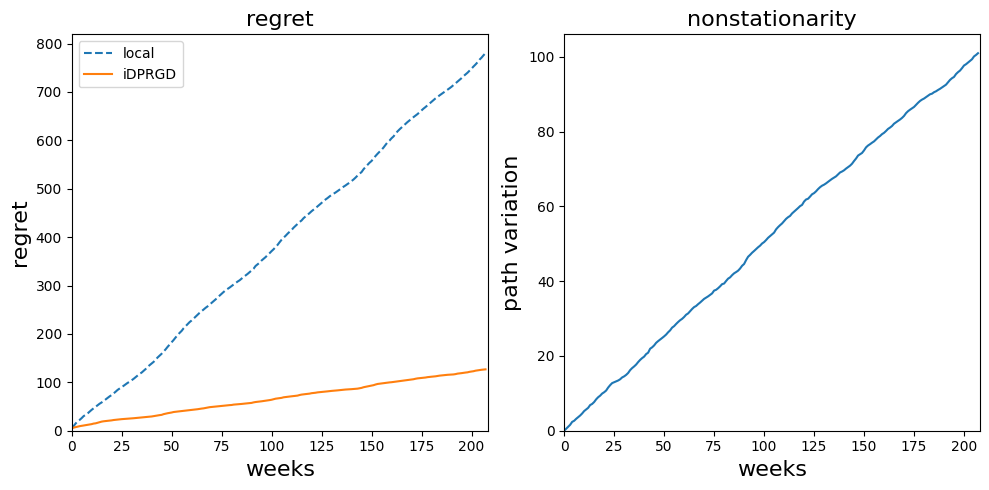

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]

ax.plot(loss_worst - loss_comparison, label = "local", linestyle = "--")
ax.plot(loss - loss_comparison, label = "iDPRGD", linestyle = "-") 
ax.legend(fontsize = 16)

ax.set_title("regret", fontsize = 16)
ax.set_ylabel("regret", fontsize = 16)
ax.set_xlabel("weeks", fontsize = 16)
ax.set_xlim(0, T)
ax.set_ylim(0, None) 


dist = np.zeros(T)
for t in range(1, T):
    dist[t] = np.mean(spd.dist(means[t], means[t-1])) + (t > 0) * dist[t - 1]

ax = axs[1]
ax.plot(dist)
ax.set_title("nonstationarity", fontsize = 16)
ax.set_ylabel("path variation", fontsize = 16)
ax.set_xlabel("weeks", fontsize = 16)
ax.set_xlim(0, T)
ax.set_ylim(0, None)

plt.tight_layout()
plt.savefig("figure/fluxnet_corr.pdf")
plt.show()

## Covariance matrices

In this section, we analyze the covariance matrices of 5 environmental variables in different sites.

In [2]:
files = glob.glob("data/processed/*_cov.csv") 
arr = []
for file in files:
    df = pd.read_csv(file, index_col = [0, 1])
    arr.append(df.to_numpy().reshape(-1, 5, 5))

data = np.stack(arr, axis = 0)
data = np.transpose(data, (1, 0, 2, 3))

T = data.shape[0]
n = data.shape[1]

folder = "data/cache/cov"

In [3]:
# load cache data without running the code again
means = np.load(folder + "/means.npy")
loss_comparison = np.load(folder + "/loss_comparison.npy")
diff_comparison = np.load(folder + "/diff_comparison.npy")

# DPRGD
loss = np.load(folder + "/loss.npy")
runtime = np.load(folder + "/runtime.npy")

# use local states only
loss_worst = np.load(folder + "/loss_worst.npy")

### Compute Frechet Mean

In [88]:
# compute the frechet means for each of the 208 weeks
means = np.zeros((T, 5, 5))
for t in tqdm(range(T)):
    means[t] = spd.frechet_mean(data[t])

# save means to data/cache
#np.save(folder + "/means.npy", means)

100%|██████████| 208/208 [29:20<00:00,  8.46s/it]


In [91]:
loss_comparison = np.zeros(T)
for t in range(T):
    loss_comparison[t] = np.mean(spd.dist(means[t], data[t]) ** 2) + (t > 0) * loss_comparison[t - 1]

diff_comparison = np.zeros(T)
for t in range(T):
    diff_comparison[t] = loss_comparison[t] - (t > 0) * loss_comparison[t - 1]
    
# save data
#np.save(folder + "/loss_comparison.npy", loss_comparison)   
#np.save(folder + "/diff_comparison.npy", diff_comparison) 

### Decentralized Optimization

In [ ]:
loss = np.zeros(T)
runtime = np.zeros(T)
stepsize = 0.1 # stepsize for local gradient descent

states = np.zeros((n, 5, 5))
states = data[0].copy() # initial state

start = time.time()

for t in tqdm(range(T)):
    local_loss = np.zeros(n)
    for i in range(n):
        local_loss[i] = np.mean(spd.dist(states[i], data[t]) ** 2)

    if np.mean(local_loss) < diff_comparison[t]:
        break

    loss[t] = np.mean(local_loss) + (t > 0) * loss[t - 1]

    new_states = np.zeros((n, 5, 5))
    for i in range(n):
        l = (i - 3) % n
        r = (i + 3) % n
        if l < r:
            neighbors = list(range(l, r + 1))
        else:
            neighbors = list(range(l, n)) + list(range(r + 1))
        vec = np.mean(spd.log(states[i], states[neighbors]), axis = 0)
        new_states[i] = spd.exp(states[i], vec)
    
    for i in range(n):
        vec = np.mean(spd.log(new_states[i], data[t, i, ...]), axis = 0)
        states[i] = spd.exp(new_states[i], stepsize * vec)
        
    end = time.time()
    runtime[t] = end - start

# save the results to data/cache
#np.save(folder + "/loss.npy", loss)
#np.save(folder + "/runtime.npy", runtime)

100%|██████████| 208/208 [19:58<00:00,  5.76s/it]


In [ ]:
# use local states as the approximation
loss_worst = np.zeros(T)
for t in range(T):
    local_loss = np.zeros(n)
    for i in range(n):
        local_loss[i] = np.mean(spd.dist(data[t, i, ...], data[t]) ** 2)
    loss_worst[t] = np.mean(local_loss) + (t > 0) * loss_worst[t - 1]

# save the results to data/cache
#np.save(folder + "/loss_worst.npy", loss_worst)

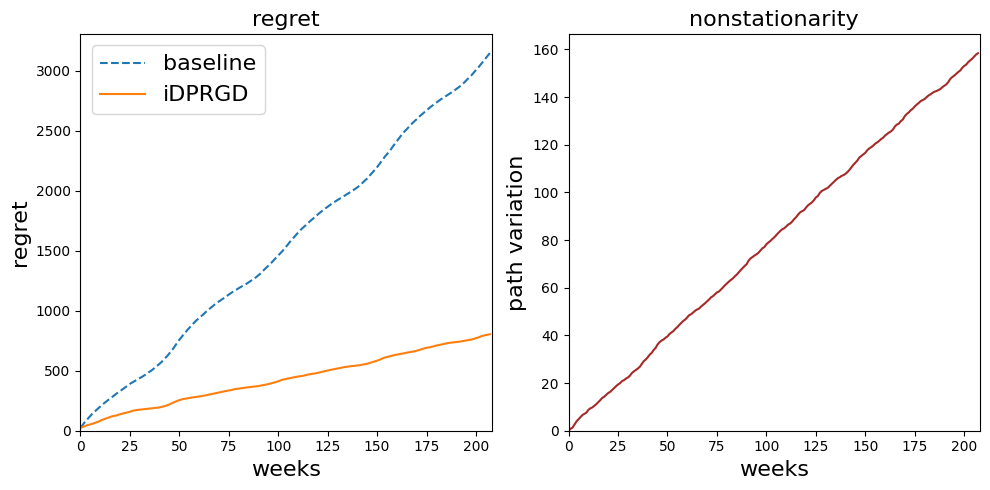

In [4]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]

ax.plot(loss_worst - loss_comparison, label = "baseline", linestyle = "--")
ax.plot(loss - loss_comparison, label = "iDPRGD", linestyle = "-") 
ax.legend(fontsize = 16)

ax.set_title("regret", fontsize = 16)
ax.set_ylabel("regret", fontsize = 16)
ax.set_xlabel("weeks", fontsize = 16)
ax.set_xlim(0, T)
ax.set_ylim(0, None) 


dist = np.zeros(T)
for t in range(1, T):
    dist[t] = np.mean(spd.dist(means[t], means[t-1])) + (t > 0) * dist[t - 1]

ax = axs[1]
ax.plot(dist, color = 'brown')
ax.set_title("nonstationarity", fontsize = 16)
ax.set_ylabel("path variation", fontsize = 16)
ax.set_xlabel("weeks", fontsize = 16)
ax.set_xlim(0, T)
ax.set_ylim(0, None)

plt.tight_layout()
plt.savefig("figure/fluxnet_cov.pdf")
plt.show()

### Consensus

In [104]:
steps = 100
states = np.zeros((n, 5, 5))
states = data[0].copy() # initial state

loss = np.zeros(steps)

for t in tqdm(range(steps)):
    local_loss = np.zeros(n)
    for i in range(n):
        local_loss[i] = np.mean(spd.dist(states[i], data[0]) ** 2)
    loss[t] = np.mean(local_loss)
    
    new_states = np.zeros((n, 5, 5))
    for i in range(n):
        l = (i - 3) % n
        r = (i + 3) % n
        if l < r:
            neighbors = list(range(l, r + 1))
        else:
            neighbors = list(range(l, n)) + list(range(r + 1))
        vec = np.mean(spd.log(states[i], states[neighbors]), axis = 0)
        new_states[i] = spd.exp(states[i], vec)
    
    states = new_states

# save the results to data/cache
np.save(folder + "/loss_consensus.npy", loss)

100%|██████████| 100/100 [08:52<00:00,  5.32s/it]


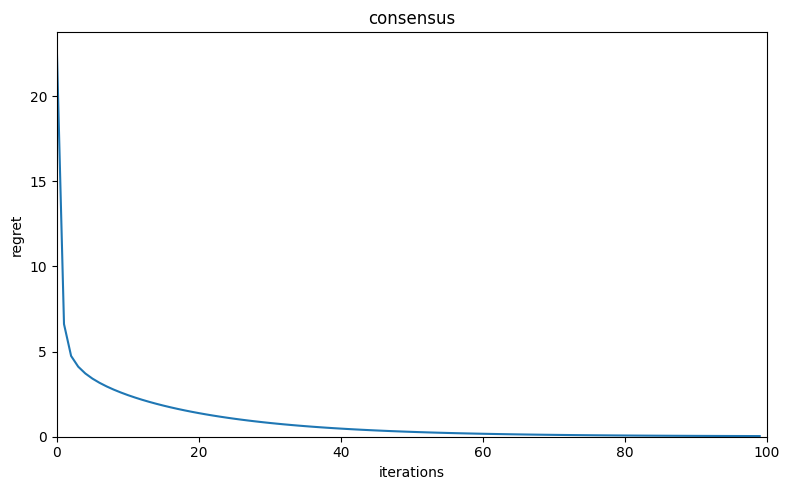

In [110]:
fig = plt.figure(figsize = (8, 5))
plt.plot(loss - loss_comparison[0])
plt.title("consensus")
plt.ylabel("regret")
plt.xlabel("iterations")
plt.xlim(0, steps)
plt.ylim(0, None)
plt.tight_layout()
plt.savefig("figure/consensus_cov.pdf")
plt.show()